Data Loading & Cleaning

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

print("Libraries loaded successfully.")




Libraries loaded successfully.


In [71]:
df = pd.read_csv('./data/movies_dataset.csv')

#Feature selection
#Based on correlation analysis, we remove redundant financial columns
#We also ignore ID and ReleaseYear for the mathematical clustering
features_to_use = [
    'BudgetUSD', 
    'Global_BoxOfficeUSD', 
    'NumVotesIMDb', 
    'NumVotesRT',
    'IMDbRating', 
    'RottenTomatoesScore'
]

X = df[features_to_use].copy()

#PREPROCESSING (Scaling y log-transform)
#We apply a log-transform to prevent very high values from dominating
for col in ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT']:
    X[col] = np.log1p(X[col])

#Critical: We must scale data because Budget is in millions and Rating is 0-10.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_use)

print("Data Preprocessing Complete.")
print(f"Features used for clustering: {features_to_use}")
print(f"Shape of training data: {X_scaled_df.shape}")

#We take a sample due to the massive number of rows
frac = 0.2
sample_indices = np.random.choice(X_scaled_df.index, size=int(frac * len(X_scaled_df)), replace=False)
X_sample = X_scaled[sample_indices]
X_sample_scaled_df = X_scaled_df.loc[sample_indices]
df_sample = df.loc[sample_indices]

print(f"Shape of sample data: {X_sample_scaled_df.shape}")

X_sample_scaled_df.head()

Data Preprocessing Complete.
Features used for clustering: ['BudgetUSD', 'Global_BoxOfficeUSD', 'NumVotesIMDb', 'NumVotesRT', 'IMDbRating', 'RottenTomatoesScore']
Shape of training data: (999999, 6)
Shape of sample data: (199999, 6)


,BudgetUSD,Global_BoxOfficeUSD,NumVotesIMDb,NumVotesRT,IMDbRating,RottenTomatoesScore
320287,-0.830139,-0.535996,-0.393771,-1.101342,2.359450,2.002197
468846,0.275005,0.686136,0.572966,0.651110,0.878572,0.126394
645226,-0.086281,-0.554550,-0.317598,-0.008142,1.551698,0.751661
119786,1.537690,1.788045,1.560766,0.311041,-1.611994,-1.180984
651074,-0.686465,-0.653059,0.222461,-0.279232,-1.342744,-0.726244


K-Means

Elbow Method

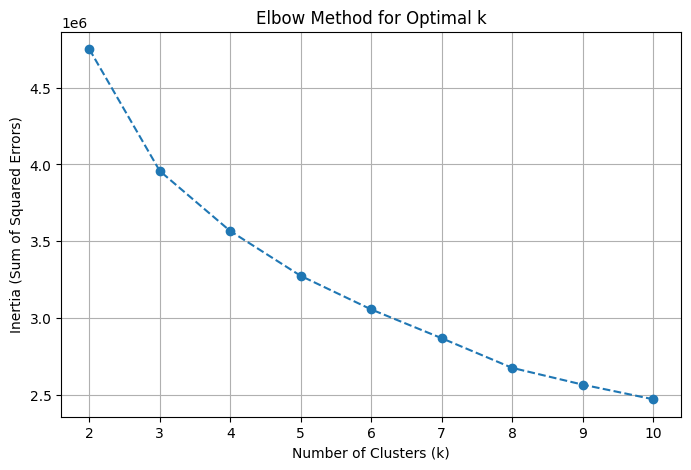

In [47]:
inertia = []
k_range = range(2, 11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Errors)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

K-Means Algorithm Implementation

In [48]:
#Assigns each data point to the closest centroid.
def find_closest_centroids(points, centroids):
    num_points = points.shape[0]
    num_centroids = centroids.shape[0]
    assignments = np.zeros(num_points, dtype=int)

    for point_index in range(num_points):
        #Calculate distance from point X[i] to all centroids as we have done in the exercises by hand
        distances = np.sum((points[point_index] - centroids) ** 2, axis=1)
        #Assign to the index of the minimum distance
        assignments[point_index] = np.argmin(distances)
    
    return assignments

#Returns new centroids by averaging points assigned to each cluster.
def compute_centroids(points, assignments, num_centroids):
    num_points, num_features = points.shape       
    new_centroids = np.zeros((num_centroids, num_features))
    for centroid_index in range(num_centroids):   
        #Points assigned to this centroid
        cluster_points = points[assignments == centroid_index]
        if len(cluster_points) > 0:
            new_centroids[centroid_index] = np.mean(cluster_points, axis=0)
    
    return new_centroids


Application

In [72]:
#I choose k based on the Elbow Plot 
k_optimal = 4
max_iters = 10

#Randomly pick k points from our sample to be the starting centroids
random_indices = np.random.choice(X_sample.shape[0], k_optimal, replace=False)
centroids = X_sample[random_indices]

assignments = np.zeros(X_sample.shape[0])

print(f"\nStarting Manual K-Means Algorithm (k={k_optimal})...")

#K means
for i in range(max_iters):
    print(f"Iteration {i+1}/{max_iters}...")
    
    #Assign points to clusters 
    assignments = find_closest_centroids(X_sample, centroids)
    
    #Calculate new centroids
    previous_centroids = centroids
    centroids = compute_centroids(X_sample, assignments, k_optimal)
    
    #Check for convergence (if centroids don't change, we stop)
    if np.all(centroids == previous_centroids):
        print("Converged early!")
        break

print("Manual Clustering Completed Successfully.")


Starting Manual K-Means Algorithm (k=4)...
Iteration 1/10...
Iteration 2/10...
Iteration 3/10...
Iteration 4/10...
Iteration 5/10...
Iteration 6/10...
Iteration 7/10...
Iteration 8/10...
Iteration 9/10...
Iteration 10/10...
Manual Clustering Completed Successfully.


Visualization and analysis

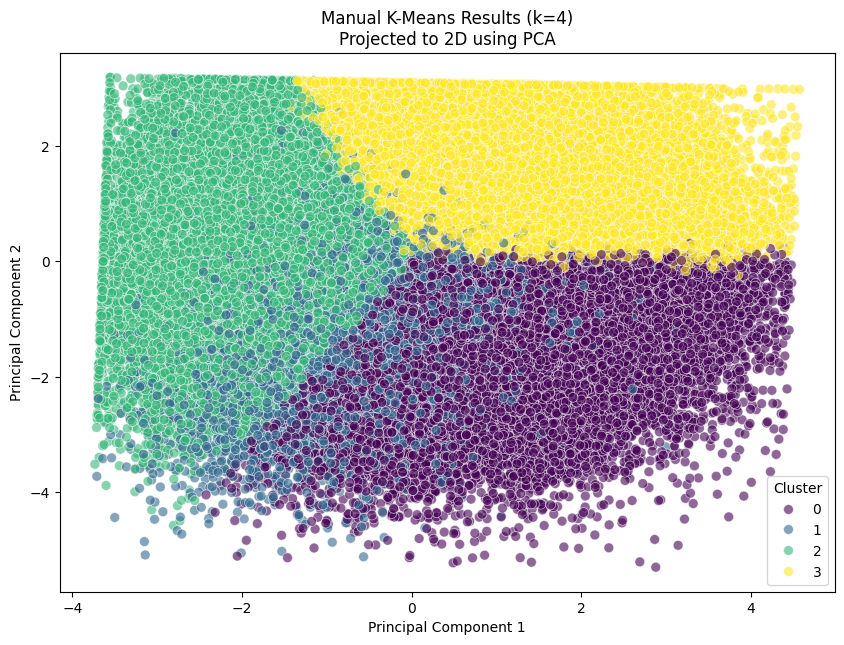


--- Cluster Profiles (Average Values) ---
            BudgetUSD  Global_BoxOfficeUSD  IMDbRating  RottenTomatoesScore
Cluster                                                                    
0        1.784443e+07         5.023808e+07    5.239912            49.731679
1        3.516418e+06         8.921195e+06    5.800970            56.430016
2        9.197625e+05         2.139365e+06    6.743918            67.887829
3        1.530495e+07         4.271696e+07    7.851135            80.957897

Movies per Cluster:
 Cluster  NumMovies
       3      56908
       2      53365
       0      50667
       1      39059


In [73]:
#VISUALIZATION (PCA 2D)
#We use PCA only to project the 6-dimensional data onto a 2D plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=assignments, 
    palette='viridis', 
    s=50, 
    alpha=0.6
)
plt.title(f'Manual K-Means Results (k={k_optimal})\nProjected to 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

#CLUSTER PROFILING
#Add the cluster labels to our sample dataframe
df_sample['Cluster'] = assignments

#Calculate the mean of the original features for each cluster
# Note: We use the original columns (before scaling) to make it readable (e.g. real dollars)
numeric_cols = ['BudgetUSD', 'Global_BoxOfficeUSD', 'IMDbRating', 'RottenTomatoesScore']
profile = df_sample.groupby('Cluster')[numeric_cols].mean()

print("\n--- Cluster Profiles (Average Values) ---")
print(profile)

#how many movies are in each cluster
print("\nMovies per Cluster:")
df_counts = df_sample['Cluster'].value_counts().reset_index()
df_counts.columns = ['Cluster', 'NumMovies']
print(df_counts.to_string(index=False))



DBSCAN

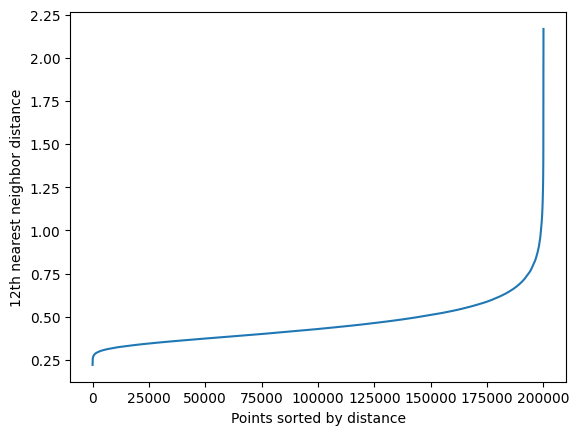

In [74]:
#We plot knn to try to choose an apropriate value for epsilon
neighbors = NearestNeighbors(n_neighbors=12)
neighbors_fit = neighbors.fit(X_sample_scaled_df)
distances, indices = neighbors_fit.kneighbors(X_sample_scaled_df)
distances = np.sort(distances[:, 11])
plt.plot(distances)
plt.ylabel("12th nearest neighbor distance")
plt.xlabel("Points sorted by distance")
plt.show()

In [75]:
clusterer = DBSCAN(eps=0.7, min_samples=12, metric='euclidean')
y_pred = clusterer.fit_predict(X_sample_scaled_df)

In [76]:
# Number of clusters and noise
unique_labels = np.unique(y_pred)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(y_pred).count(-1)  # O np.sum(y_pred == -1)

print(f"Número de clústers: {n_clusters}")
print(f"Número de puntos de ruido: {n_noise}")
print(f"Etiquetas únicas de clústers: {unique_labels[unique_labels != -1]}")  # Excluye -1

# We asign clusters in the DataFrame to see the details
df_sample['Cluster'] = y_pred
print("\nTamaños de cada clúster (incluyendo ruido como -1):")
print(df_sample.groupby('Cluster').size())

# Example: first 10 movies in each cluster
for cluster_id in unique_labels:
    if cluster_id != -1:
        print(f"\nClúster {cluster_id}:")
        print(df_sample[df_sample['Cluster'] == cluster_id][['Title', 'Genre', 'IMDbRating']].head(10))

Número de clústers: 1
Número de puntos de ruido: 2960
Etiquetas únicas de clústers: [0]

Tamaños de cada clúster (incluyendo ruido como -1):
Cluster
-1      2960
 0    197039
dtype: int64

Clúster 0:
                      Title     Genre  IMDbRating
320287   Task serve picture   Romance        10.0
468846             Try true     Drama         7.8
645226      Lay own company    Comedy         8.8
119786     Security exactly   Romance         4.1
651074         Evening wait    Comedy         4.5
715178             Analysis  Thriller         3.9
386007             They and    Comedy         4.8
890828  Quickly dog someone    Comedy         4.7
549353           Late month    Comedy         5.6
82230             Or series     Drama         6.4
